In [1]:
cd ..

/Users/flamholz/Documents/workspace/ccm_evolution


In [2]:
mkdir -p figures/fig2

In [3]:
import numpy as np
import pandas as pd
import re
import seaborn as sns

from matplotlib import pyplot as plt
from hnea_genes import *

In [4]:
locus2plot = [g for g, props in genes_of_interest.items()
              if categories2plot.get(props['kind'], False)]

# base DF has a column per condition-replicate
barseq_df = pd.read_csv('data/Hnea/barseq/fit_logratios_all_good.csv')

# long-form DF made for plotting purposes - one row per data point
long_df = pd.read_csv('data/Hnea/barseq/fit_logratios_all_long.csv')
long_df.head()

,locus_id,variable,value,gene_tag,gene_name,cond,rep,ccm_gene
0,GFF1190,5% CO2,-0.000402,other,NaN,5% CO2,0,False
1,GFF1209,5% CO2,0.222629,other,NaN,5% CO2,0,False
2,GFF1357,5% CO2,-0.612701,other,NaN,5% CO2,0,False
3,GFF1439,5% CO2,-0.277288,other,NaN,5% CO2,0,False
4,GFF1496,5% CO2,0.676934,other,NaN,5% CO2,0,False


In [5]:
# Shorter data frame for faster plotting of main-text genes.
mask = long_df.locus_id.isin(genes_of_interest.keys())
long_subset_df_allreps = long_df[mask]

# Only plot 2 replicates per CO2 cond. 
# We have 4 reps for 5%, but it makes the plot more confusing.
mask = np.logical_and(mask, long_df.rep < 3)
long_subset_df = long_df[mask]

long_subset_df.head()

,locus_id,variable,value,gene_tag,gene_name,cond,rep,ccm_gene
192,HNEAP_RS01030,5% CO2,-0.009401,transport,DAB2B,5% CO2,0,True
193,HNEAP_RS01035,5% CO2,0.052684,transport,DAB2A,5% CO2,0,True
194,HNEAP_RS01040,5% CO2,0.104180,regulation,LysR DAB2,5% CO2,0,True
648,HNEAP_RS04565,5% CO2,0.015781,carboxysome,csos1D,5% CO2,0,True
650,HNEAP_RS04575,5% CO2,-0.129304,chaperone,cbbQ,5% CO2,0,True


In [6]:
# Total number of genes considered
long_df.locus_id.unique().size

1728

In [7]:
# Calculate the IQR of fitness measurements for each of the CO2 conditions
median_fitness_series = long_df.groupby('cond').median()['value'].rename('median')
bot_fitness_series  = long_df.groupby('cond').quantile(0.25)['value'].rename('bottom')
top_fitness_series = long_df.groupby('cond').quantile(0.75)['value'].rename('top')
tmp = pd.concat([median_fitness_series, bot_fitness_series, top_fitness_series], axis=1)

# Across the whole dataset
median_fitness = long_df.value.median()
bot_quartile_fitness = long_df.value.quantile(0.25)
top_quartile_fitness = long_df.value.quantile(0.75)
print('Median fitness value over all experiments %.3g' % median_fitness)
print('IQR = (%.3g, %.3g)' % (bot_quartile_fitness, top_quartile_fitness))

print('Per CO2 condition')
tmp

Median fitness value over all experiments -0.0231
IQR = (-0.148, 0.0648)
Per CO2 condition


,median,bottom,top
cond,,,
0.5% CO2,-0.017437,-0.140040,0.077791
1.5% CO2,-0.033340,-0.170428,0.054025
10% CO2,-0.015358,-0.135522,0.073933
5% CO2,-0.027191,-0.149242,0.056724
ambient CO2,-0.021527,-0.147207,0.068630


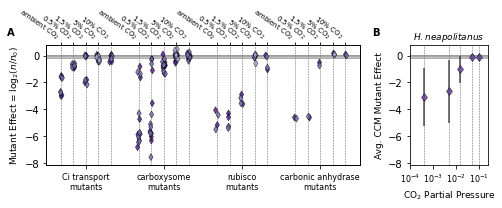

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(7,3), gridspec_kw={'width_ratios': [4,1]})
hue_order = 'ambient CO2,0.5% CO2,1.5% CO2,5% CO2,10% CO2'.split(',')
xorder = 'transport,carboxysome,carboxysomal rubisco,CA'.split(',')
pal = sns.color_palette('Purples', n_colors=8)
greys = sns.color_palette('Greys')

plt.sca(axs[0])
for rep in long_subset_df.rep.unique():
    mask = long_subset_df.rep == rep
    my_df = long_subset_df[mask]
    sns.stripplot(data=my_df, x='gene_tag', y='value', hue='cond', dodge=0.25,
                  order=xorder, hue_order=hue_order, alpha=0.85,
                  marker='d', edgecolor='k', linewidth=0.5, palette=[pal[-2*rep-1]])

ax = plt.gca()
bottom = [bot_quartile_fitness, bot_quartile_fitness]
top = [top_quartile_fitness, top_quartile_fitness]
plt.fill_between([0,1], bottom, top, color=greys[-3], alpha=0.5, transform=ax.get_yaxis_transform())
plt.axhline(median_fitness, lw=0.3, color=greys[-1])
plt.legend().set_visible(False)

xticks = 'Ci transport\nmutants,carboxysome\nmutants,rubisco\nmutants,carbonic anhydrase\nmutants'.split(',')
plt.xticks(np.arange(len(xticks)), xticks, rotation=0, ha='center', fontsize=8)
plt.ylabel('Mutant Effect = $\log_2 (n/n_0)$', fontsize=9)
plt.xlabel('')

axs[0].text(-0.1, 1.15, 'A', transform=axs[0].transAxes,
      fontsize=10, fontweight='bold', va='top', ha='right')
xticks = np.arange(0, 0.8, 0.16) - 0.32
xticks = np.hstack([xticks, xticks+1, xticks+2, xticks+3])
xticks_str = 'ambient CO$_2$,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$,10% CO$_2$'.split(',')*4
for xpos in xticks:
    plt.axvline(xpos, ls='--', lw=0.5, zorder=-1, color=greys[-2])
plt.ylim(-8.15, 0.8)


ax = plt.gca()
axT = ax.twiny()
plt.sca(axT)

plt.xticks(xticks, xticks_str, ha='right', rotation=-35, fontsize=7)
plt.tick_params(pad=0)
plt.xlim(ax.get_xlim())


# Right panel - mean fitness effect
plt.sca(axs[1])
plt.xscale('log')

# Band for typical mutational effect.
bottom = [bot_quartile_fitness, bot_quartile_fitness]
top = [top_quartile_fitness, top_quartile_fitness]
plt.fill_between([0,1], bottom, top, color=greys[-3], alpha=0.5, transform=axs[1].get_yaxis_transform())
plt.axhline(median_fitness, lw=0.3, color=greys[-1])

# Mean effect for CCM genes
mean_per_cond = long_subset_df.groupby('cond').mean()
std_per_cond = long_subset_df.groupby('cond').std()
str2co2level = {'0.5% CO2':0.5e-2, '1.5% CO2':1.5e-2, '10% CO2':10e-2, '5% CO2':5e-2, 'ambient CO2':0.04e-2}
co2_levels = [str2co2level[x] for x in mean_per_cond.index]
plt.errorbar(co2_levels, mean_per_cond.value, yerr=std_per_cond.value,
             marker='d', markersize=6, markeredgecolor='k', markeredgewidth=0.5, alpha=0.85,
             ls='', ecolor=greys[-1], markerfacecolor=pal[-2])

axs[1].text(-0.39, 1.15, 'B', transform=axs[1].transAxes,
      fontsize=10, fontweight='bold', va='top', ha='right')
xs = np.logspace(-4, -1, 4)
plt.xticks(xs, fontsize=8)
plt.xlim(1e-4, 0.25)
plt.ylim(-8.15, 0.8)
plt.xlabel('CO$_2$ Partial Pressure', fontsize=9)
plt.ylabel('Avg. CCM Mutant Effect', fontsize=9)
plt.title('$H. neapolitanus$', fontsize=9)

for xpos in co2_levels:
    plt.axvline(xpos, ls='--', lw=0.5, zorder=-1, color=greys[-2])
    
plt.tight_layout()
plt.savefig('figures/fig2/fig2.png', dpi=600, facecolor='w')
plt.savefig('figures/fig2/fig2.pdf', dpi=600, facecolor='w')

plt.show()

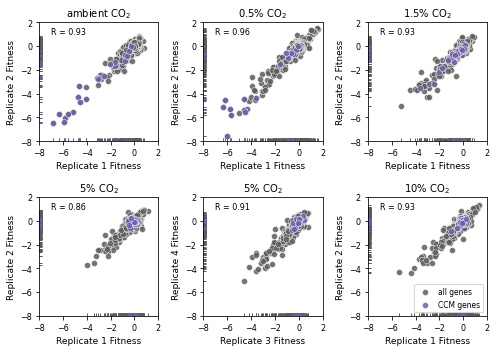

In [9]:
reps = range(1)
conds = 'ambient CO2,0.5% CO2,1.5% CO2,5% CO2,5% CO2,10% CO2'.split(',')
reps = [(0, 1), (0, 1), (0, 1), (0, 1), (2, 3), (0, 1)]
titles = 'ambient CO$_2$,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$,5% CO$_2$,10% CO$_2$'.split(',')*7
greys = sns.color_palette('Greys')
purples = sns.color_palette('Purples')


fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7,5))

for i, (ax, cond) in enumerate(zip(axs.flatten(), conds)):
    plt.sca(ax)
    
    rep1, rep2 = reps[i]
    mask1 = np.logical_and(long_df.cond == cond, long_df.rep == rep1)
    mask2 = np.logical_and(long_df.cond == cond, long_df.rep == rep2)
    sub_df1 = long_df[mask1].set_index('locus_id').sort_index()
    sub_df2 = long_df[mask2].set_index('locus_id').sort_index()
    
    # Remove genes with NAN fitness values
    no_nans = np.logical_and(np.isfinite(sub_df1.value), 
                             np.isfinite(sub_df2.value))
    sub_df1 = sub_df1[no_nans]
    sub_df2 = sub_df2[no_nans]
    
    # Put correlation on the plot
    R = np.corrcoef(sub_df1.value, sub_df2.value)
    txt = 'R = {0:.2f}'.format(R[1,0])
    plt.text(0.1, 0.9, txt, fontsize=8,
             transform=ax.transAxes)
    
    plt.scatter(sub_df1.value, sub_df2.value, color=greys[-2], edgecolor='w',
                lw=0.5, alpha=0.85, label='all genes')
    sns.rugplot(x=sub_df1.value, y=sub_df2.value, color=greys[-2])

    ccm_genes1 = sub_df1.ccm_gene == True
    ccm_genes2 = sub_df2.ccm_gene == True
    plt.scatter(sub_df1[ccm_genes1].value, sub_df2[ccm_genes2].value,
                color=purples[-2], edgecolor='w', lw=0.5, alpha=0.85,
                label='CCM genes')
    sns.rugplot(x=sub_df1[ccm_genes1].value, y=sub_df2[ccm_genes2].value,
                color=purples[-2])
    
    plt.xlabel('Replicate {0} Fitness'.format(rep1 + 1), fontsize=9)
    plt.ylabel('Replicate {0} Fitness'.format(rep2 + 1), fontsize=9)
    plt.title(titles[i], fontsize=10)
    plt.xlim(-8, 2)
    plt.ylim(-8, 2)
    plt.xticks(np.arange(-8, 2.1, 2), fontsize=8)
    plt.yticks(np.arange(-8, 2.1, 2), fontsize=8)
    
plt.legend(loc=4, fontsize=7.5)
plt.tight_layout()
plt.savefig('figures/fig2/fig2_S1.png', dpi=600, facecolor='w')
plt.show()

In [10]:
# Can't plot pairwise data with biological duplicates, so we take the mean fitness per-gene first.
mean_fitness_df = long_df.groupby(['locus_id', 'cond']).mean().reset_index()
mean_fitness_df = mean_fitness_df.pivot('locus_id', 'cond')['value']

# Add categorical information.
default_props = dict(kind='other', name=None)
gene_tags = [genes_of_interest.get(locus_id, default_props)['kind'] 
             for locus_id, row in mean_fitness_df.iterrows()]
gene_names = [genes_of_interest.get(locus_id, default_props)['name'] 
              for locus_id, row in mean_fitness_df.iterrows()]
mean_fitness_df['gene_tag'] = gene_tags
mean_fitness_df['gene_name'] = gene_names
mean_fitness_df['ccm_gene'] = mean_fitness_df['gene_tag'] != 'other'

# Determine the order of plotting manually so that the interesting genes go on top in scatter plots below
tag_order = 'other,transport,carboxysome,carboxysomal rubisco,CA,regulation,chaperone,non-carboxysomal rubisco'.split(',')
tag_order = dict((tag, i) for i, tag in enumerate(tag_order))
mean_fitness_df['gene_tag_order'] = [tag_order[g] for g in mean_fitness_df['gene_tag']]
mean_fitness_df.sort_values('gene_tag_order', ascending=True, inplace=True)

mean_fitness_df.head()

cond,0.5% CO2,1.5% CO2,10% CO2,5% CO2,ambient CO2,gene_tag,gene_name,ccm_gene,gene_tag_order
locus_id,,,,,,,,,
GFF1190,-0.080285,0.021461,-0.079133,-0.001788,0.049010,other,None,False,0
HNEAP_RS08360,-0.499066,-0.549026,-0.801773,-0.252179,-0.273166,other,None,False,0
HNEAP_RS08355,-0.018733,0.019661,-0.068799,-0.061447,-0.021375,other,None,False,0
HNEAP_RS08350,-0.017921,0.094072,0.116095,-0.032568,-0.011143,other,None,False,0
HNEAP_RS08345,-0.035667,0.016089,0.011404,0.051005,0.064591,other,None,False,0


/Users/flamholz/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/flamholz/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/flamholz/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

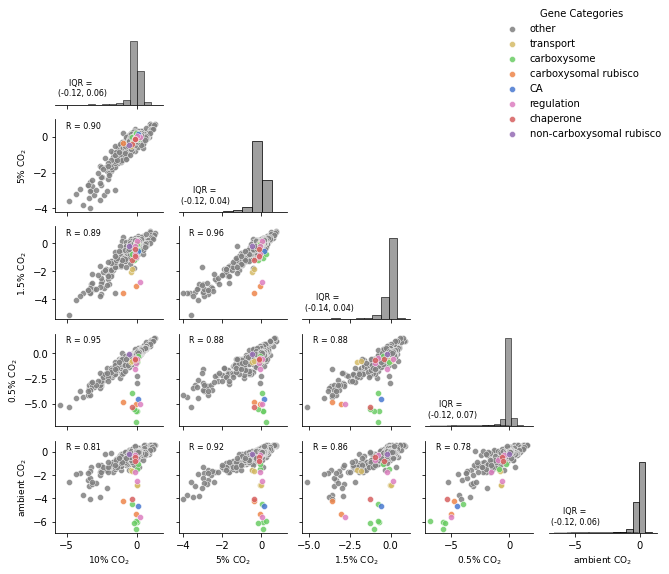

In [11]:
co2_order = 'ambient CO2,0.5% CO2,1.5% CO2,5% CO2,10% CO2'.split(',')[::-1]
co2_labels = 'ambient CO$_2$,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$,10% CO$_2$'.split(',')[::-1]

# muted has a grey in it - drop it
tmp_pal = sns.color_palette('muted', n_colors=9)
tmp_pal = tmp_pal[:7] + tmp_pal[-1:]

tags = sorted(mean_fitness_df.gene_tag.unique())
pal = dict((c, tmp_pal[i]) for i, c in enumerate(tags))
pal['other'] = 'grey'

def my_histplot(x, **kwargs):
    my_kwargs = kwargs.copy()
    my_kwargs['color'] = kwargs['palette'][0]
    sns.histplot(x, **my_kwargs)
    
    if kwargs['label'] == 'other':
        bot_quartile_fitness = x.quantile(0.25)
        top_quartile_fitness = x.quantile(0.75)
        ax = plt.gca()
        txt = 'IQR = \n({0:.2f}, {1:.2f})'.format(bot_quartile_fitness, top_quartile_fitness)
        plt.text(0.25, 0.1, txt, fontsize=8,
                 transform=ax.transAxes, ha='center')
        
def my_scatterplot(x, y, **kwargs):
    my_kwargs = kwargs.copy()
    my_kwargs['color'] = kwargs['palette'][kwargs['label']]
    sns.scatterplot(x, y, **my_kwargs)
    
    if kwargs['label'] == 'other':
        mask = np.logical_not(np.logical_or(np.isnan(x), np.isnan(y)))
        R = np.corrcoef(x[mask].values, y[mask].values)
        ax = plt.gca()
        txt = 'R = {0:.2f}'.format(R[1,0])
        plt.text(0.1, 0.9, txt, fontsize=8,
                 transform=ax.transAxes)

g = sns.PairGrid(mean_fitness_df, vars=co2_order, hue='gene_tag', corner=True)
g.fig.set_size_inches(7,8)
g.map_diag(my_histplot, palette=['grey']*8, binwidth=0.5)
g.map_lower(my_scatterplot, palette=pal, edgecolors='k', linewidths=0.5, alpha=0.85)
g = g.add_legend(fontsize=10, loc=1, title='Gene Categories')

for ylabel, ax in zip(co2_labels, g.axes[:,0]):
    ax.set_ylabel(ylabel, fontsize=9)
for xlabel, ax in zip(co2_labels, g.axes[-1,:]):
    ax.set_xlabel(xlabel, fontsize=9)

plt.tight_layout()
plt.savefig('figures/fig2/fig2_S2.png', dpi=600, facecolor='w')
plt.show()

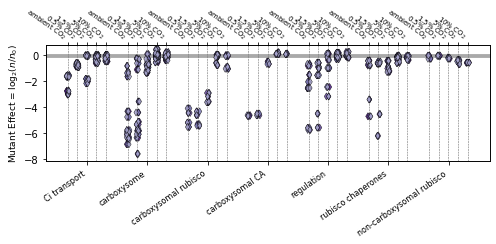

In [12]:
# Longer version of the main-text figure.
hue_order = 'ambient CO2,0.5% CO2,1.5% CO2,5% CO2,10% CO2'.split(',')
xorder = 'transport,carboxysome,carboxysomal rubisco,CA,regulation,chaperone,non-carboxysomal rubisco'.split(',')
pal = sns.color_palette('Purples', n_colors=12)
greys = sns.color_palette('Greys')

ls_df = long_subset_df_allreps

fig, ax = plt.subplots(figsize=(7,3.5))

for rep in ls_df.rep.unique():
    mask = ls_df.rep == rep
    my_df = ls_df[mask]
    sns.stripplot(data=ls_df, x='gene_tag', y='value', hue='cond', dodge=0.25,
                  order=xorder, hue_order=hue_order, alpha=0.85,
                  marker='d', edgecolor='k', linewidth=0.5, palette=[pal[-2*rep-1]],
                  jitter=0.15)
    
plt.legend().set_visible(False)

xtick_str = 'Ci transport,carboxysome,carboxysomal rubisco,carboxysomal CA,regulation,rubisco chaperones,non-carboxysomal rubisco'.split(',')
plt.xticks(np.arange(len(xtick_str)), xtick_str, rotation=35, ha='right', fontsize=8)
plt.ylabel('Mutant Effect = $\log_2 (n/n_0)$', fontsize=9)
plt.xlabel('')
plt.ylim(-8.15, 0.8)

# Band for typical mutational effect.
bottom = [bot_quartile_fitness, bot_quartile_fitness]
top = [top_quartile_fitness, top_quartile_fitness]
plt.fill_between([0,1], bottom, top, color=greys[-3], alpha=0.5, transform=ax.get_yaxis_transform())
plt.axhline(median_fitness, lw=0.3, color=greys[-1])

xticks = np.arange(0, 0.8, 0.16) - 0.325
xticks = np.hstack([xticks, xticks+1, xticks+2, xticks+3, xticks+4, xticks+5, xticks+6])
xticks_str = 'ambient CO$_2$,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$,10% CO$_2$'.split(',')*7

for xpos in xticks:
    plt.axvline(xpos, ls='--', lw=0.5, zorder=-1, color=greys[-2])

ax = plt.gca()
axT = ax.twiny()
plt.sca(axT)

plt.xlim(ax.get_xlim())
plt.xticks(xticks, xticks_str, ha='right', rotation=-35, fontsize=7)
plt.tick_params(pad=0)

plt.tight_layout()
plt.savefig('figures/fig2/fig2_S3.png', dpi=600, facecolor='w')
plt.show()

In [13]:
# Calculate correlation of fitness with pCO2 for all genes
from scipy.stats import pearsonr
cols = ['ambient CO2', '0.5% CO2', '1.5% CO2', '5% CO2', '10% CO2' ]
co2_conc_pct = np.array([0.04, 0.5, 1.5, 5, 10])

annot_df = pd.read_csv('data/Hnea/barseq/2017_11_03_miseq_barSeq1/genes', sep='\t', index_col=0)

corr_df = annot_df.merge(mean_fitness_df, left_index=True, right_index=True)
corr_df['CO2_Rval'] = np.NaN
corr_df['CO2_Pval'] = np.NaN

for idx, row in mean_fitness_df.iterrows():
    gene_fitness = np.array(row[cols].values, dtype=np.float32)
    if np.isnan(gene_fitness).any():
        continue
        
    Rval, p = pearsonr(co2_conc_pct, gene_fitness)
    corr_df.at[idx, 'CO2_Rval'] = Rval
    corr_df.at[idx, 'abs_CO2_Rval'] = np.abs(Rval)
    corr_df.at[idx, 'CO2_Pval'] = p

In [14]:
corr_df['mean_effect_size'] = np.abs(corr_df[cols].mean(axis=1))
col_order = ['begin', 'end', 'strand', 'gene_name', 'desc', 'GC', 'nTA', 
             'ambient CO2', '0.5% CO2', '5% CO2', '1.5% CO2', '10% CO2', 
             'CO2_Rval']

ccm_corr = corr_df[corr_df.ccm_gene == True]
for_output = ccm_corr.sort_values('abs_CO2_Rval', ascending=False)[col_order].round(3)

for_output.to_csv('data/Hnea/barseq/ccm_gene_mean_fitness.csv')
for_output.head(3)

,begin,end,strand,gene_name,desc,GC,nTA,ambient CO2,0.5% CO2,5% CO2,1.5% CO2,10% CO2,CO2_Rval
HNEAP_RS05505,1184110,1185489,-,cbbM,ribulose-bisphosphate carboxylase,0.548,28,-0.147,-0.041,-0.474,-0.219,-0.567,-0.933
HNEAP_RS04660,989858,991279,-,cbbL,ribulose bisphosphate carboxylase large chain,0.532,40,-5.339,-5.004,-0.056,-3.035,-0.030,0.887
HNEAP_RS05490,1179635,1180537,+,LysR cbbM (catA),LysR family transcriptional regulator,0.523,31,-5.650,-5.018,0.013,-2.798,0.214,0.886


In [15]:
# Get all genes with fittness effect and correlation at least as high as any CCM gene
mask = np.logical_and(corr_df.abs_CO2_Rval > 0.6, corr_df['ambient CO2'] < -0.5)
masked_corr_df = corr_df[mask]

for_output = masked_corr_df.sort_values('abs_CO2_Rval', ascending=False)[col_order].round(3)

for_output.to_csv('data/Hnea/barseq/genes_correlated_to_CO2.csv')
for_output.head(3)

,begin,end,strand,gene_name,desc,GC,nTA,ambient CO2,0.5% CO2,5% CO2,1.5% CO2,10% CO2,CO2_Rval
HNEAP_RS11630,2503955,2504815,-,None,chromosome partitioning protein ParB,0.585,12,-1.141,-1.052,-1.008,-1.124,-0.792,0.952
HNEAP_RS11640,2505629,2506309,-,None,16S rRNA (guanine(527)-N(7))-methyltransferase...,0.554,19,-0.675,-0.658,-0.619,-0.662,-0.371,0.945
HNEAP_RS11300,2434506,2435198,+,None,phosphate regulon transcriptional regulatory p...,0.596,8,-0.683,-0.689,-0.800,-0.832,-1.170,-0.935


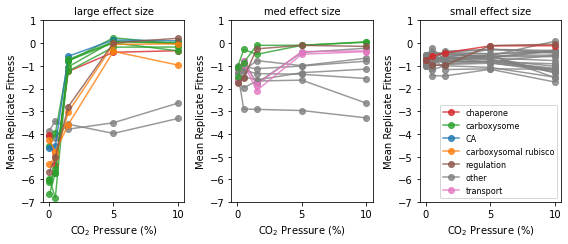

In [16]:
fig, axs = plt.subplots(ncols=3, figsize=(8,3.5))

pal = sns.color_palette(n_colors=masked_corr_df.shape[0])

large_effect = masked_corr_df[masked_corr_df['ambient CO2'] < -2]
mask = np.logical_and(masked_corr_df['ambient CO2'] < -1, 
                      masked_corr_df['ambient CO2'] >= -2)
med_effect = masked_corr_df[mask]
small_effect = masked_corr_df[masked_corr_df['ambient CO2'] > -1]
titles = 'large effect size,med effect size,small effect size'.split(',')

tag2color = dict((t, pal[i]) for i, t in enumerate(sorted(masked_corr_df.gene_tag.unique())))
tag2color['other'] = 'grey'

# Keep track of unique labels in a dict
legend_labels = dict()
for i, (my_df, my_ax) in enumerate(zip([large_effect, med_effect, small_effect], axs)):
    plt.sca(my_ax)
    plt.xlabel('CO$_2$ Pressure (%)')
    plt.ylabel('Mean Replicate Fitness')
    plt.ylim(-7, 1)
    plt.title(titles[i], fontsize=10)
    for j, (idx, row) in enumerate(my_df.iterrows()):
        # Color by tag, put CCM genes on top
        c = tag2color[row.gene_tag]
        z = 1 if row.gene_tag == 'other' else 2
        plt.plot(co2_conc_pct, row[cols], color=c, label=row.gene_tag,
                 zorder=z, alpha=0.8, ls='-', marker='o')
    
    handles, labels = my_ax.get_legend_handles_labels()
    legend_labels.update(dict(zip(labels, handles)))

plt.legend(legend_labels.values(), legend_labels.keys(), loc=4, fontsize=8)

plt.tight_layout()
plt.savefig('figures/fig2/fitness_corr_co2.png', facecolor='w', dpi=600)
plt.show()

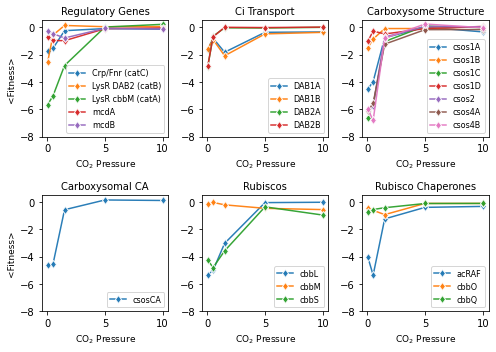

In [17]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7,5))

titles2tags = {'Regulatory Genes': ['regulation'],
               'Ci Transport': ['transport'],
               'Carboxysome Structure': ['carboxysome'],
               'Carboxysomal CA': ['CA'],
               'Rubiscos': ['carboxysomal rubisco', 'non-carboxysomal rubisco'],
               'Rubisco Chaperones': ['chaperone']
               }

pal = sns.color_palette(n_colors=15)
for i, (title, ax) in enumerate(zip(titles2tags.keys(), axs.flatten())):
    tags = titles2tags[title]
    sub_df = corr_df[corr_df.gene_tag.isin(tags)].sort_values('gene_name')
    plt.sca(ax)
    for j, (idx, row) in enumerate(sub_df.iterrows()):
        # Color by tag, put CCM genes on top
        plt.plot(co2_conc_pct, row[cols], color=pal[j], 
                 label=row.gene_name, alpha=0.95, ls='-',
                 marker='d', markeredgecolor='w', markersize=6)
    
    plt.title(title, fontsize=10)
    plt.legend(fontsize=8, loc=4)
    plt.xlabel('CO$_2$ Pressure', fontsize=9)
    plt.ylim(-8, 0.5)
    if i % 3 == 0:
        plt.ylabel('<Fitness>', fontsize=9)

plt.tight_layout()
plt.savefig('figures/fig2/fig2_S4.png', facecolor='w', dpi=600)
plt.show()

<ipython-input-18-e23540b3c9db>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  large_effect = non_ccm_genes[masked_corr_df['ambient CO2'] < -2]
<ipython-input-18-e23540b3c9db>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  small_effect = non_ccm_genes[masked_corr_df['ambient CO2'] > -1]


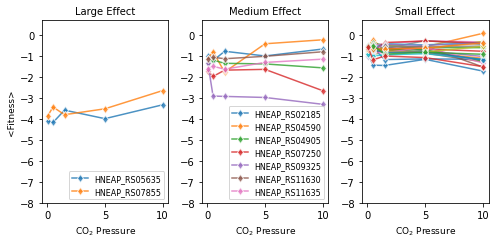

In [18]:
fig, axs = plt.subplots(ncols=3, figsize=(7,3.5))

non_ccm_genes = masked_corr_df[masked_corr_df['gene_tag'] == 'other']
large_effect = non_ccm_genes[masked_corr_df['ambient CO2'] < -2]
mask = np.logical_and(non_ccm_genes['ambient CO2'] < -1, 
                      non_ccm_genes['ambient CO2'] >= -2)
med_effect = non_ccm_genes[mask]
small_effect = non_ccm_genes[masked_corr_df['ambient CO2'] > -1]
titles = 'Large Effect,Medium Effect,Small Effect'.split(',')

pal = sns.color_palette(n_colors=non_ccm_genes.index.size)
for i, (my_df, my_ax) in enumerate(zip([large_effect, med_effect, small_effect], axs)):
    plt.sca(my_ax)
    for j, (idx, row) in enumerate(my_df.iterrows()):
        color = pal[j]
        plt.plot(co2_conc_pct, row[cols], color=color, label=idx,
                 alpha=0.8, ls='-', marker='d', markeredgecolor='w')
        
    plt.title(titles[i], fontsize=10)
    
    plt.xlabel('CO$_2$ Pressure', fontsize=9)
    plt.ylim(-8, 0.7)
    if i % 3 == 0:
        plt.ylabel('<Fitness>', fontsize=9)
    if my_df.shape[0] < 10:
        plt.legend(fontsize=8, loc=4)

plt.tight_layout()
plt.savefig('figures/fig2/fig2_S5.png', facecolor='w', dpi=600)
plt.show()